In [29]:
# Import our dependencies
import psycopg2 as pg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import datetime as dt
import tensorflow as tf

In [30]:
# Postgres Connection
#engine = pg.connect("dbname='Capstone_Project' user='postgres' host='127.0.0.1' port='5432' password=''")
#usaf_df = pd.read_sql("select * from usaf_complete", con=engine)

#usaf_df.head()

In [31]:
# Temporary CSV connection to work with model
 
usaf_df = pd.read_csv("https://raw.githubusercontent.com/CPotts82/Project_Practice/main/usaf_complete.csv")
usaf_df.head()

,Crash_Date,Crash_Time,Aircraft_SN,Aircraft_Type,Summarized_Name,Ejection_Seats,Base,Wing,Squadron,Mission_Type,...,Longitude,Defense_Type,Defense_Category,Pilot_Hit,Pilot_Rank,Pilot,Pilot_Egress,Pilot_Condition,Pilot_Recovered,Pilot_Status
0,1962-02-11 00:00:00,_,4315732,SC-47A,C-47 Skytrain,N,BHA,_,4400CCTS,NaN,...,107.0,Gunfire (combat associated),Automatic Weapons,_,Capt,Kissam E. K.,Crash,_,_,KIA
1,1962-08-28 00:00:00,_,538376,T-28B,T-28 Trojan,N,_,_,_,NaN,...,NaN,Gunfire,Automatic Weapons,_,Capt,Simpson R. L.,_,_,_,KIA
2,1962-10-15 00:00:00,_,625909,U-10,U-10 Courier,N,_,_,_,NaN,...,NaN,Gunfire,Automatic Weapons,_,Capt,Booth H. W.,Crash,_,_,KIA
3,1962-10-16 00:00:00,_,538365,T-28B,T-28 Trojan,N,_,_,_,NaN,...,NaN,Gunfire,Automatic Weapons,_,Capt,Chambers B. L.,Ejection,Minor injuries,_,Recovered
4,1962-11-05 00:00:00,_,4435530,RB-26B,B-26 Invader,N,_,_,_,NaN,...,NaN,Gunfire,Automatic Weapons,_,Capt,Bennett R. D.,Crash,_,_,KIA


## Preprocessing the Data


In [32]:
# Create dataframe with variables for model

nn_model = usaf_df.filter(['Crash_Date','Summarized_Name', 'Defense_Category', 'Ejection_Seats', 'Pilot_Egress', 'Mission_Phase', 'Pilot_Status'], axis=1)

nn_model.head()

,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Mission_Phase,Pilot_Status
0,1962-02-11 00:00:00,C-47 Skytrain,Automatic Weapons,N,Crash,_,KIA
1,1962-08-28 00:00:00,T-28 Trojan,Automatic Weapons,N,_,_,KIA
2,1962-10-15 00:00:00,U-10 Courier,Automatic Weapons,N,Crash,_,KIA
3,1962-10-16 00:00:00,T-28 Trojan,Automatic Weapons,N,Ejection,_,Recovered
4,1962-11-05 00:00:00,B-26 Invader,Automatic Weapons,N,Crash,At target,KIA


In [33]:
# Convert Crash_Date to datetime data type
nn_model["Crash_Date"] = pd.to_datetime(nn_model["Crash_Date"])
nn_model.head()

,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Mission_Phase,Pilot_Status
0,1962-02-11,C-47 Skytrain,Automatic Weapons,N,Crash,_,KIA
1,1962-08-28,T-28 Trojan,Automatic Weapons,N,_,_,KIA
2,1962-10-15,U-10 Courier,Automatic Weapons,N,Crash,_,KIA
3,1962-10-16,T-28 Trojan,Automatic Weapons,N,Ejection,_,Recovered
4,1962-11-05,B-26 Invader,Automatic Weapons,N,Crash,At target,KIA


In [34]:
# Check to see what years are present in converted dates
nn_model["Crash_Date"].dt.year.unique()

array([1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973])

In [35]:
# Check data type to ensure date conversion
nn_model.dtypes

Crash_Date          datetime64[ns]
Summarized_Name             object
Defense_Category            object
Ejection_Seats              object
Pilot_Egress                object
Mission_Phase               object
Pilot_Status                object
dtype: object

In [36]:
# Check for '_' string values

#nn_model.loc[nn_model["Pilot_Egress"] == '_'].count()
#nn_model.loc[nn_model["Crash_Date"] == '_'].count()
#nn_model.loc[nn_model["Summarized_Name"] == '_'].count()
#nn_model.loc[nn_model["Defense_Category"] == '_'].count()
#nn_model.loc[nn_model["Ejection_Seats"] == '_'].count()
#nn_model.loc[nn_model["Mission_Phase"] == '_'].count()
nn_model.loc[nn_model["Pilot_Status"] == '_'].count()

Crash_Date          3
Summarized_Name     3
Defense_Category    3
Ejection_Seats      3
Pilot_Egress        3
Mission_Phase       3
Pilot_Status        3
dtype: int64

In [37]:
# Remove rows that have string value "_".

nn_model = nn_model[(nn_model.Pilot_Egress != '_') & (nn_model.Mission_Phase != '_') & (nn_model.Pilot_Status != '_')]
nn_model.head()

,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Mission_Phase,Pilot_Status
4,1962-11-05,B-26 Invader,Automatic Weapons,N,Crash,At target,KIA
5,1963-02-03,B-26 Invader,Small Arms Fire,N,Crash,At target,KIA
7,1963-04-08,B-26 Invader,Automatic Weapons,N,Crash,At target,KIA
17,1964-01-14,T-28 Trojan,Automatic Weapons,N,Crashlanded,At target,Recovered
19,1964-02-19,T-28 Trojan,Automatic Weapons,N,Crash,At target,KIA


In [38]:
# Check to ensure '_' values have been dropped
nn_model.loc[nn_model["Pilot_Egress"] == '_'].count()

Crash_Date          0
Summarized_Name     0
Defense_Category    0
Ejection_Seats      0
Pilot_Egress        0
Mission_Phase       0
Pilot_Status        0
dtype: int64

In [39]:
# Determine the number of unique values in each column.
nn_model.nunique()

Crash_Date          754
Summarized_Name      27
Defense_Category      7
Ejection_Seats        2
Pilot_Egress          6
Mission_Phase         5
Pilot_Status         12
dtype: int64

In [41]:
# Instead of binning by year - Create a new column, Crash_Year, in the dataframe
nn_model['Crash_Year'] = pd.DatetimeIndex(nn_model['Crash_Date']).year
nn_model.head()

,Crash_Date,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Mission_Phase,Pilot_Status,Crash_Year
4,1962-11-05,B-26 Invader,Automatic Weapons,N,Crash,At target,KIA,1962
5,1963-02-03,B-26 Invader,Small Arms Fire,N,Crash,At target,KIA,1963
7,1963-04-08,B-26 Invader,Automatic Weapons,N,Crash,At target,KIA,1963
17,1964-01-14,T-28 Trojan,Automatic Weapons,N,Crashlanded,At target,Recovered,1964
19,1964-02-19,T-28 Trojan,Automatic Weapons,N,Crash,At target,KIA,1964


In [42]:
# Drop Crash_Date column - will only use Crash_Year in model
nn_model.drop(['Crash_Date'], axis = 1, inplace=True)
nn_model.head()

,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Mission_Phase,Pilot_Status,Crash_Year
4,B-26 Invader,Automatic Weapons,N,Crash,At target,KIA,1962
5,B-26 Invader,Small Arms Fire,N,Crash,At target,KIA,1963
7,B-26 Invader,Automatic Weapons,N,Crash,At target,KIA,1963
17,T-28 Trojan,Automatic Weapons,N,Crashlanded,At target,Recovered,1964
19,T-28 Trojan,Automatic Weapons,N,Crash,At target,KIA,1964


In [45]:
# Check Crash_Year value counts for binning by year (if necessary)
year_counts = nn_model.Crash_Year.value_counts()
year_counts

1966    223
1967    220
1968    185
1969    111
1965     93
1970     64
1972     63
1971     33
1964     13
1973      8
1963      2
1962      1
Name: Crash_Year, dtype: int64

In [46]:
# Look at Summarized_Name value counts for binning
name_counts = nn_model.Summarized_Name.value_counts()
name_counts

F-105 Thunderchief     269
F-4 Phantom            244
F-100 Super Sabre      153
A-1 Skyraider          127
O-1 Bird Dog            35
O-2 Skymaster           31
B-57 Canberra           22
F-101 Voodoo            22
OV-10 Bronco            18
C-130 Hercules          16
C-123 Provider          11
A-37 Dragonfly           9
AC-47 Gunship I          9
T-28 Trojan              8
F-5 Tiger                7
C-7 Caribou              7
F-104 Starfighter        6
B-52 Stratofortress      5
A-26 Invader             4
A-7 Corsair              3
B-26 Invader             3
C-47 Skytrain            2
C-119 Flying Boxcar      1
HU-16 Albatross          1
F-102 Delta Dagger       1
B-66 Destroyer           1
F-111 Aardvark           1
Name: Summarized_Name, dtype: int64

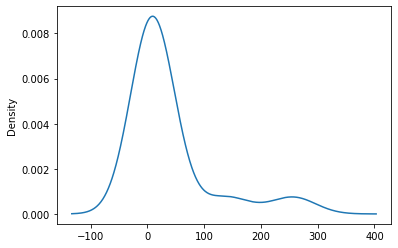

In [47]:
# Visualize the value counts of Summarized_Name
name_counts.plot.density()

In [48]:
# Determine which values to replace if counts are less than ...?
replace_names = list(name_counts[name_counts < 18].index)

# Replace in dataframe
for name in replace_names:
    nn_model.Summarized_Name = nn_model.Summarized_Name.replace(name,"Other")
    
# Check to make sure binning was successful
nn_model.Summarized_Name.value_counts()

F-105 Thunderchief    269
F-4 Phantom           244
F-100 Super Sabre     153
A-1 Skyraider         127
Other                  95
O-1 Bird Dog           35
O-2 Skymaster          31
B-57 Canberra          22
F-101 Voodoo           22
OV-10 Bronco           18
Name: Summarized_Name, dtype: int64

In [49]:
# Look at Pilot_Status value counts for categories
pilot_counts = nn_model.Pilot_Status.value_counts()
pilot_counts

Recovered                  511
KIA                        296
POW (returned)             141
MIA                         51
POW (died)                   5
POW                          3
KIA (chute failure)          3
Recoverd                     2
KIA (chute failed)           1
Recovered DaNang             1
POW (died in captivity)      1
recovered                    1
Name: Pilot_Status, dtype: int64

In [50]:
# Clean the Target variable - Create binomial

status = {'Recovered': 1, 'KIA': 0,'POW (returned)': 1,'MIA': 0,'POW (died)': 0,'POW': 1,'KIA (chute failure)': 0,'Recoverd': 1, 'u': 0, 
    'KIA (chute failed)': 0, 'Recovered DaNang': 1, 'POW (died in captivity)':0, 'Recovered (chute fail)': 1,'recovered': 1,'KIA,body MIA,PJ abandnd': 1, 'POW (died in captivity)': 0}

nn_df = nn_model.replace({"Pilot_Status": status})
nn_df.head(10)

,Summarized_Name,Defense_Category,Ejection_Seats,Pilot_Egress,Mission_Phase,Pilot_Status,Crash_Year
4,Other,Automatic Weapons,N,Crash,At target,0,1962
5,Other,Small Arms Fire,N,Crash,At target,0,1963
7,Other,Automatic Weapons,N,Crash,At target,0,1963
17,Other,Automatic Weapons,N,Crashlanded,At target,1,1964
19,Other,Automatic Weapons,N,Crash,At target,0,1964
20,Other,Automatic Weapons,N,Crash,At target,0,1964
22,Other,Automatic Weapons,N,Crash,At target,0,1964
23,Other,Automatic Weapons,N,Ejection,At target,1,1964
24,B-57 Canberra,Automatic Weapons,Y,Crash,Enroute,0,1964
28,A-1 Skyraider,AAA,Y,Crash,Enroute,0,1964


In [51]:
nn_model.dtypes

Summarized_Name     object
Defense_Category    object
Ejection_Seats      object
Pilot_Egress        object
Mission_Phase       object
Pilot_Status        object
Crash_Year           int64
dtype: object

In [52]:
# Determine the number of unique values in each column after binning and adding Crash_Year
nn_df.nunique()

Summarized_Name     10
Defense_Category     7
Ejection_Seats       2
Pilot_Egress         6
Mission_Phase        5
Pilot_Status         2
Crash_Year          12
dtype: int64

In [53]:
# Generate our categorical variable lists
nn_cat = nn_df.dtypes[nn_df.dtypes == "object"].index.tolist()
nn_cat

['Summarized_Name',
 'Defense_Category',
 'Ejection_Seats',
 'Pilot_Egress',
 'Mission_Phase']

In [54]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(nn_df[nn_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(nn_cat)
encode_df.head()

,Summarized_Name_A-1 Skyraider,Summarized_Name_B-57 Canberra,Summarized_Name_F-100 Super Sabre,Summarized_Name_F-101 Voodoo,Summarized_Name_F-105 Thunderchief,Summarized_Name_F-4 Phantom,Summarized_Name_O-1 Bird Dog,Summarized_Name_O-2 Skymaster,Summarized_Name_OV-10 Bronco,Summarized_Name_Other,...,Pilot_Egress_Crashlanded,Pilot_Egress_Crld at AB,Pilot_Egress_Crld at UBN,Pilot_Egress_Crld at UDN,Pilot_Egress_Ejection,Mission_Phase_At target,Mission_Phase_Enroute,Mission_Phase_On station,Mission_Phase_Return,Mission_Phase_Transit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [55]:
# Merge one-hot encoded features and drop the originals
nn_df = nn_df.merge(encode_df, left_index=True, right_index=True)
nn_df = nn_df.drop(nn_cat, 1)
nn_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


,Pilot_Status,Crash_Year,Summarized_Name_A-1 Skyraider,Summarized_Name_B-57 Canberra,Summarized_Name_F-100 Super Sabre,Summarized_Name_F-101 Voodoo,Summarized_Name_F-105 Thunderchief,Summarized_Name_F-4 Phantom,Summarized_Name_O-1 Bird Dog,Summarized_Name_O-2 Skymaster,...,Pilot_Egress_Crashlanded,Pilot_Egress_Crld at AB,Pilot_Egress_Crld at UBN,Pilot_Egress_Crld at UDN,Pilot_Egress_Ejection,Mission_Phase_At target,Mission_Phase_Enroute,Mission_Phase_On station,Mission_Phase_Return,Mission_Phase_Transit
4,0,1962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0,1963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0,1963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
17,1,1964,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
19,0,1964,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [56]:
# Check to ensure total number of rows meets 1000 row min criteria
print(nn_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 4 to 1014
Data columns (total 32 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Pilot_Status                        714 non-null    int64  
 1   Crash_Year                          714 non-null    int64  
 2   Summarized_Name_A-1 Skyraider       714 non-null    float64
 3   Summarized_Name_B-57 Canberra       714 non-null    float64
 4   Summarized_Name_F-100 Super Sabre   714 non-null    float64
 5   Summarized_Name_F-101 Voodoo        714 non-null    float64
 6   Summarized_Name_F-105 Thunderchief  714 non-null    float64
 7   Summarized_Name_F-4 Phantom         714 non-null    float64
 8   Summarized_Name_O-1 Bird Dog        714 non-null    float64
 9   Summarized_Name_O-2 Skymaster       714 non-null    float64
 10  Summarized_Name_OV-10 Bronco        714 non-null    float64
 11  Summarized_Name_Other               714 non-

## Process Data 

In [57]:
# Split our preprocessed data into our features and target arrays
y = nn_df["Pilot_Status"].values 
X = nn_df.drop(["Pilot_Status"], 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [59]:
len(X_train[0])

31

In [66]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 = 3
hidden_nodes_layer2 = 3
hidden_nodes_layer3 = 4

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation='relu'))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation='tanh'))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation='sigmoid'))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 96        
                                                                 
 dense_4 (Dense)             (None, 3)                 12        
                                                                 
 dense_5 (Dense)             (None, 4)                 16        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [68]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [69]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch',
    period = 5
    )

In [70]:
# Train the model
fit_model = nn.fit(X_train, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
17/17 [==============================] - 1s 2ms/step - loss: 0.6379 - accuracy: 0.6710
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.6364 - accuracy: 0.6710
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.6357 - accuracy: 0.6710
Epoch 4/100
17/17 [==============================] - 0s 2ms/step - loss: 0.6349 - accuracy: 0.6710
Epoch 5/100
 1/17 [>.............................] - ETA: 0s - loss: 0.6046 - accuracy: 0.7188
Epoch 5: saving model to checkpoints/weights.05.hdf5
17/17 [==============================] - 0s 3ms/step - loss: 0.6343 - accuracy: 0.6710
Epoch 6/100
17/17 [==============================] - 0s 2ms/step - loss: 0.6341 - accuracy: 0.6710
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 0.6340 - accuracy: 0.6710
Epoch 8/100
17/17 [==============================] - 0s 2ms/step - loss: 0.6338 - accuracy: 0.6710
Epoch 9/100
17/17 [==============================] - 0s 2ms/step - loss:

In [71]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

6/6 - 0s - loss: 0.6867 - accuracy: 0.5978 - 139ms/epoch - 23ms/step
Loss: 0.6867201924324036, Accuracy: 0.5977653861045837
